# Train-test of single PINN poisson

In [1]:
from xpinn import XPINN
import optax
from type_util import Array
from jax import hessian, jacobian, jit, vmap
import jax.numpy as np
import numpy as onp
import sys
from tqdm import tqdm
from utils import data_path
from base_network import neural_network
from poisson.poisson_utils import (
    boundary_loss_factory,
    interior_loss_factory,
    crude_rel_L2,
    interface_loss_factory,
)
from jax.nn import sigmoid
import plotutils

In [2]:
# ## Run meshing
# %run XPINN_points.py
# %run XPINN_test_points.py

In [3]:
file = data_path / "poisson_train.json"
file_test = data_path / "poisson_test.json"
activation = np.tanh

# Set model (FFNN)
xpinn = XPINN(file, activation)
model = neural_network(activation)
v_model = vmap(model, (None, 0))

In [4]:
# Set losses
def rhs(x):
    return np.where(
        (x[0] >= 0.25) & (x[0] <= 0.75) & (
            x[1] >= 0.25) & (x[1] <= 0.75), -1, 0
    )


p0, p1 = xpinn.PINNs
p0.boundary_loss = boundary_loss_factory(p0, 0.0, weight=20)
p0.interior_loss = interior_loss_factory(p0, rhs)  # implementing rhs
p1.interior_loss = interior_loss_factory(p1, rhs)
p0.interface_loss = interface_loss_factory(xpinn, 0, 1, weight=20)
p1.interface_loss = interface_loss_factory(xpinn, 1, 0, weight=20)

In [5]:
# Initializing optimizer
shapes = [[2] + [20] * 7 + [1]] * 2
exponential_decay = optax.exponential_decay(
    init_value=0.001,
    transition_steps=10000,
    transition_begin=15000,
    decay_rate=0.1,
    end_value=0.0000001,
)
optimizer = optax.adam(learning_rate=exponential_decay)
xpinn.initialize_params(shapes, optimizer)
xpinn.set_loss()

In [6]:
n_iter = 200000
losses = xpinn.run_iters(n_iter)

0.00% iter = 0 of 200000: Total loss = 4.1440078020095825
10.00% iter = 20000 of 200000: Total loss = 0.047937437891960144
20.00% iter = 40000 of 200000: Total loss = 0.035484934225678444
30.00% iter = 60000 of 200000: Total loss = 0.03194091096520424
40.00% iter = 80000 of 200000: Total loss = 0.03097341675311327
50.00% iter = 100000 of 200000: Total loss = 0.03004596848040819
60.00% iter = 120000 of 200000: Total loss = 0.02911689504981041
70.00% iter = 140000 of 200000: Total loss = 0.028178028762340546
80.00% iter = 160000 of 200000: Total loss = 0.027214771136641502
90.00% iter = 180000 of 200000: Total loss = 0.026216519996523857
100.00% iter = 200000 of 200000: Total loss = 0.025174547918140888


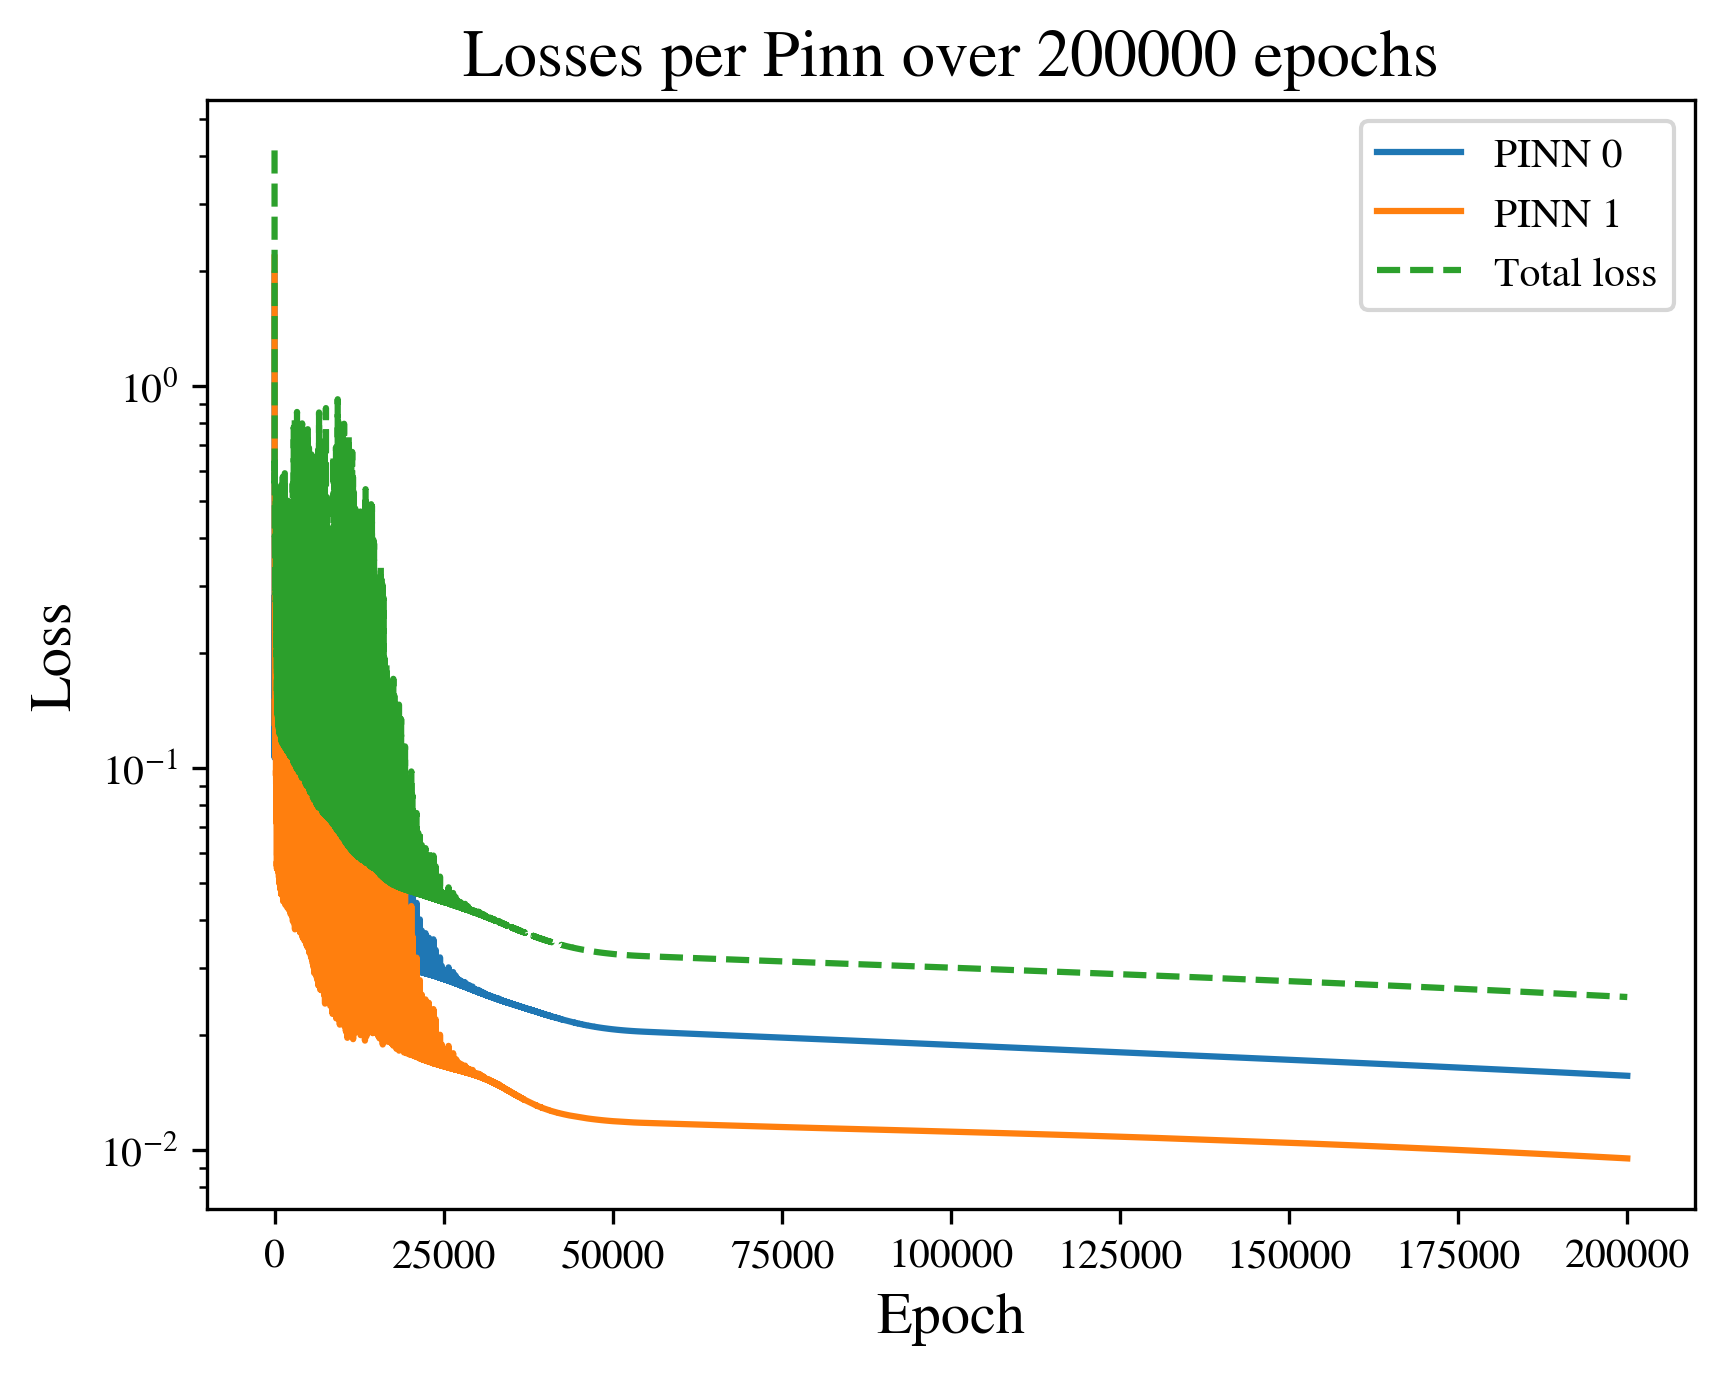

In [7]:
from plotutils import plot_losses

save_path = data_path.parent / "figures/Poisson"

plot_losses(
    losses,
    n_iter,
    title=f"Losses per Pinn over {n_iter} epochs",
    savepath=save_path,
    save_name="discrete_xpinn_Poisson_losses",
)
# a_losses = losses
# t_0 = 0
# t_end = min(200000, n_iter)
# t = np.arange(t_0, t_end)

# for i in range(2):
#     plt.plot(t, a_losses[i, t_0:t_end], label=f"PINN {i}")
# plt.plot(t, np.sum(a_losses, axis=0)[t_0:t_end], "--", label="Total loss")
# plt.xlabel("epoch")
# plt.ylabel("loss")
# plt.yscale("log")
# plt.legend()
# plt.title(f"Loss per Pinn over {n_iter} epochs")

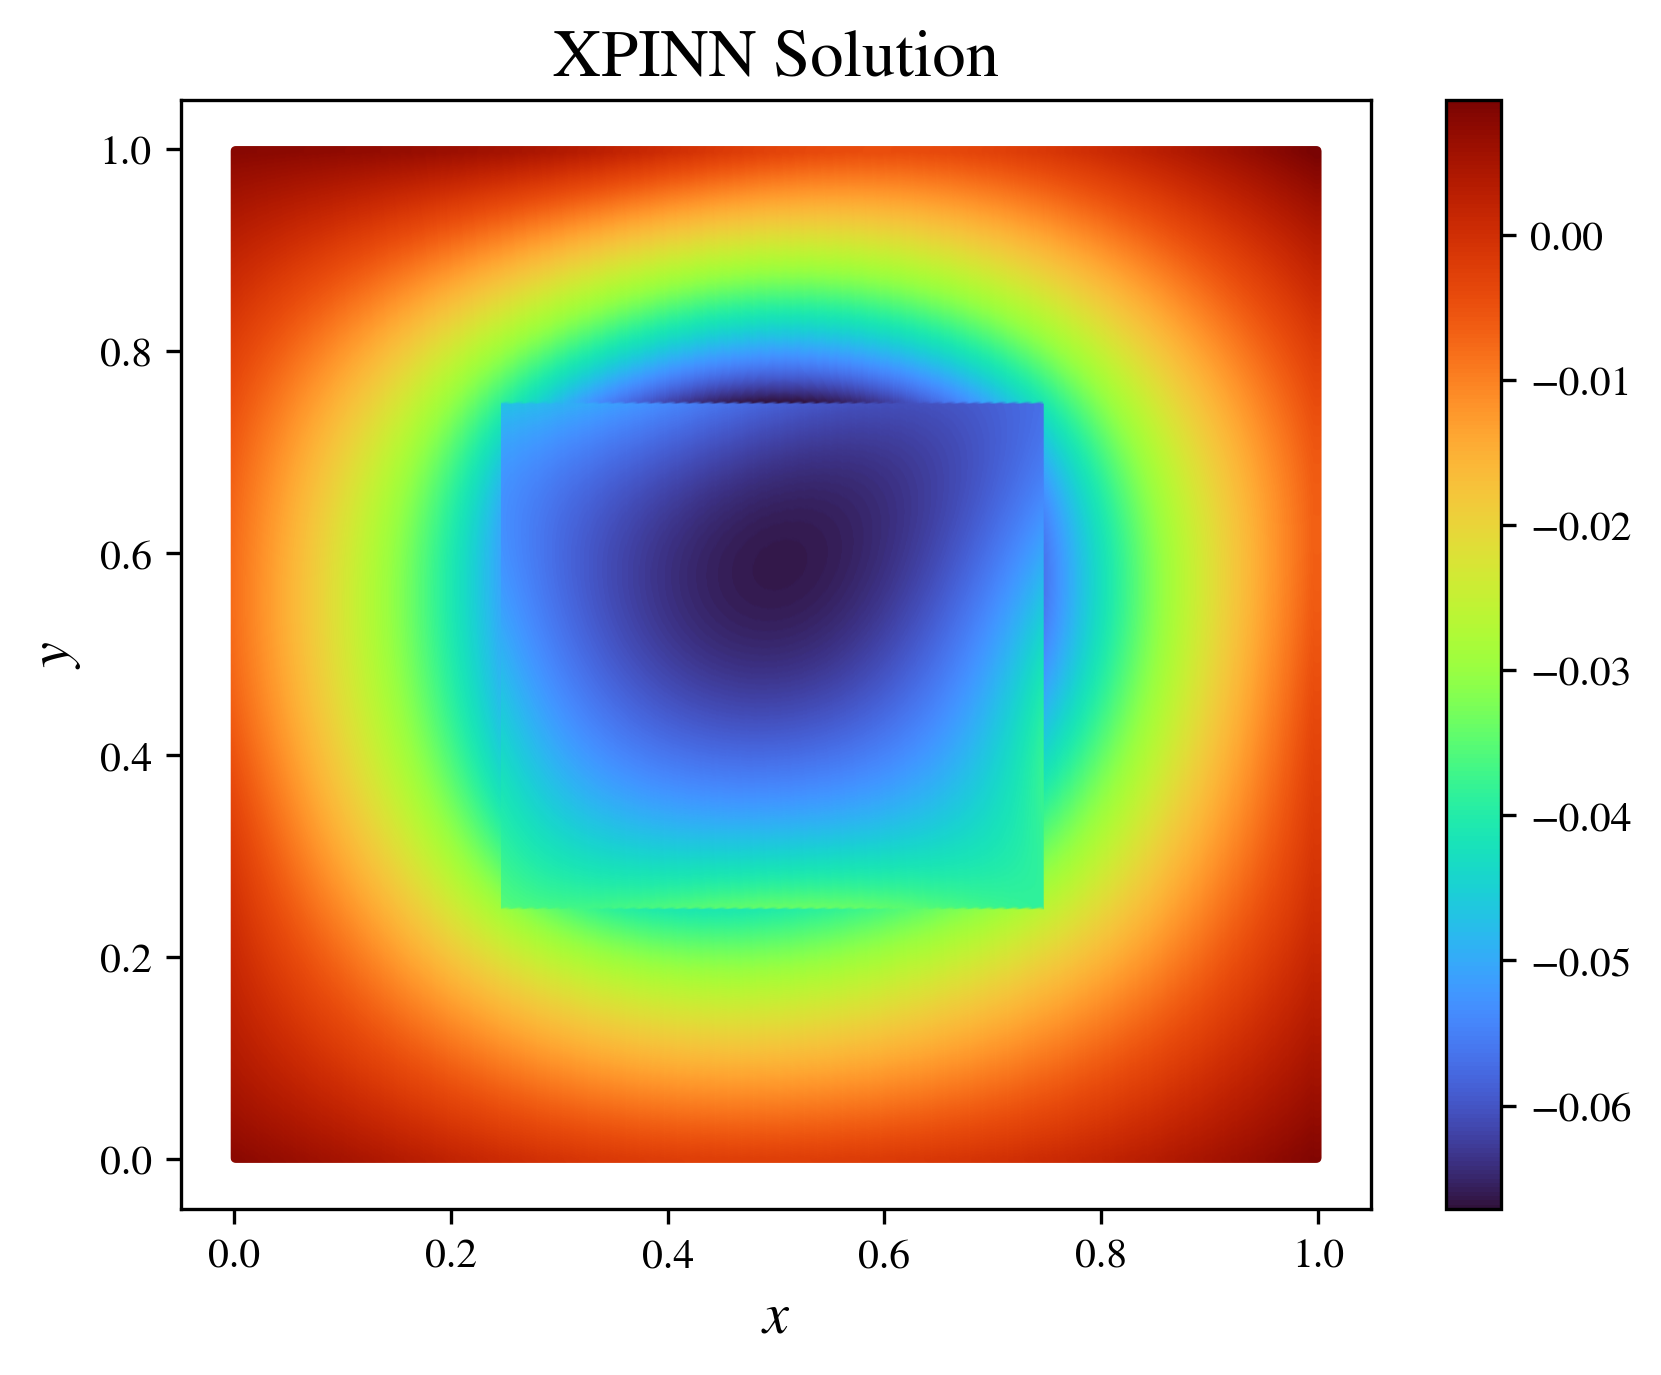

In [8]:
from plotutils import plot_poisson

points, predictions = xpinn.predict(file_test)
total_pred = np.concatenate(predictions)
total_points = np.concatenate(points)


sorted_indices = np.lexsort((total_points[:, 1], total_points[:, 0]))
total_pred = total_pred[sorted_indices]
total_points = total_points[sorted_indices]

plot_poisson(
    total_points,
    total_pred,
    savepath=save_path,
    save_name="discrete_xpinn_Poisson_solution",
    title="XPINN Solution",
)

# min_, max_ = total_pred.min(), total_pred.max()


# #plt.scatter(sorted_points[:, 0], sorted_points[:, 1], c=sorted_pred, cmap="turbo")
# plt.scatter(total_points[:, 0], total_points[:, 1], c=total_pred, cmap="turbo")
# plt.xlabel("x")
# plt.ylabel("y")
# plt.title("XPINN1 Solution")
# #plt.clim(min_, max_)

# plt.colorbar()

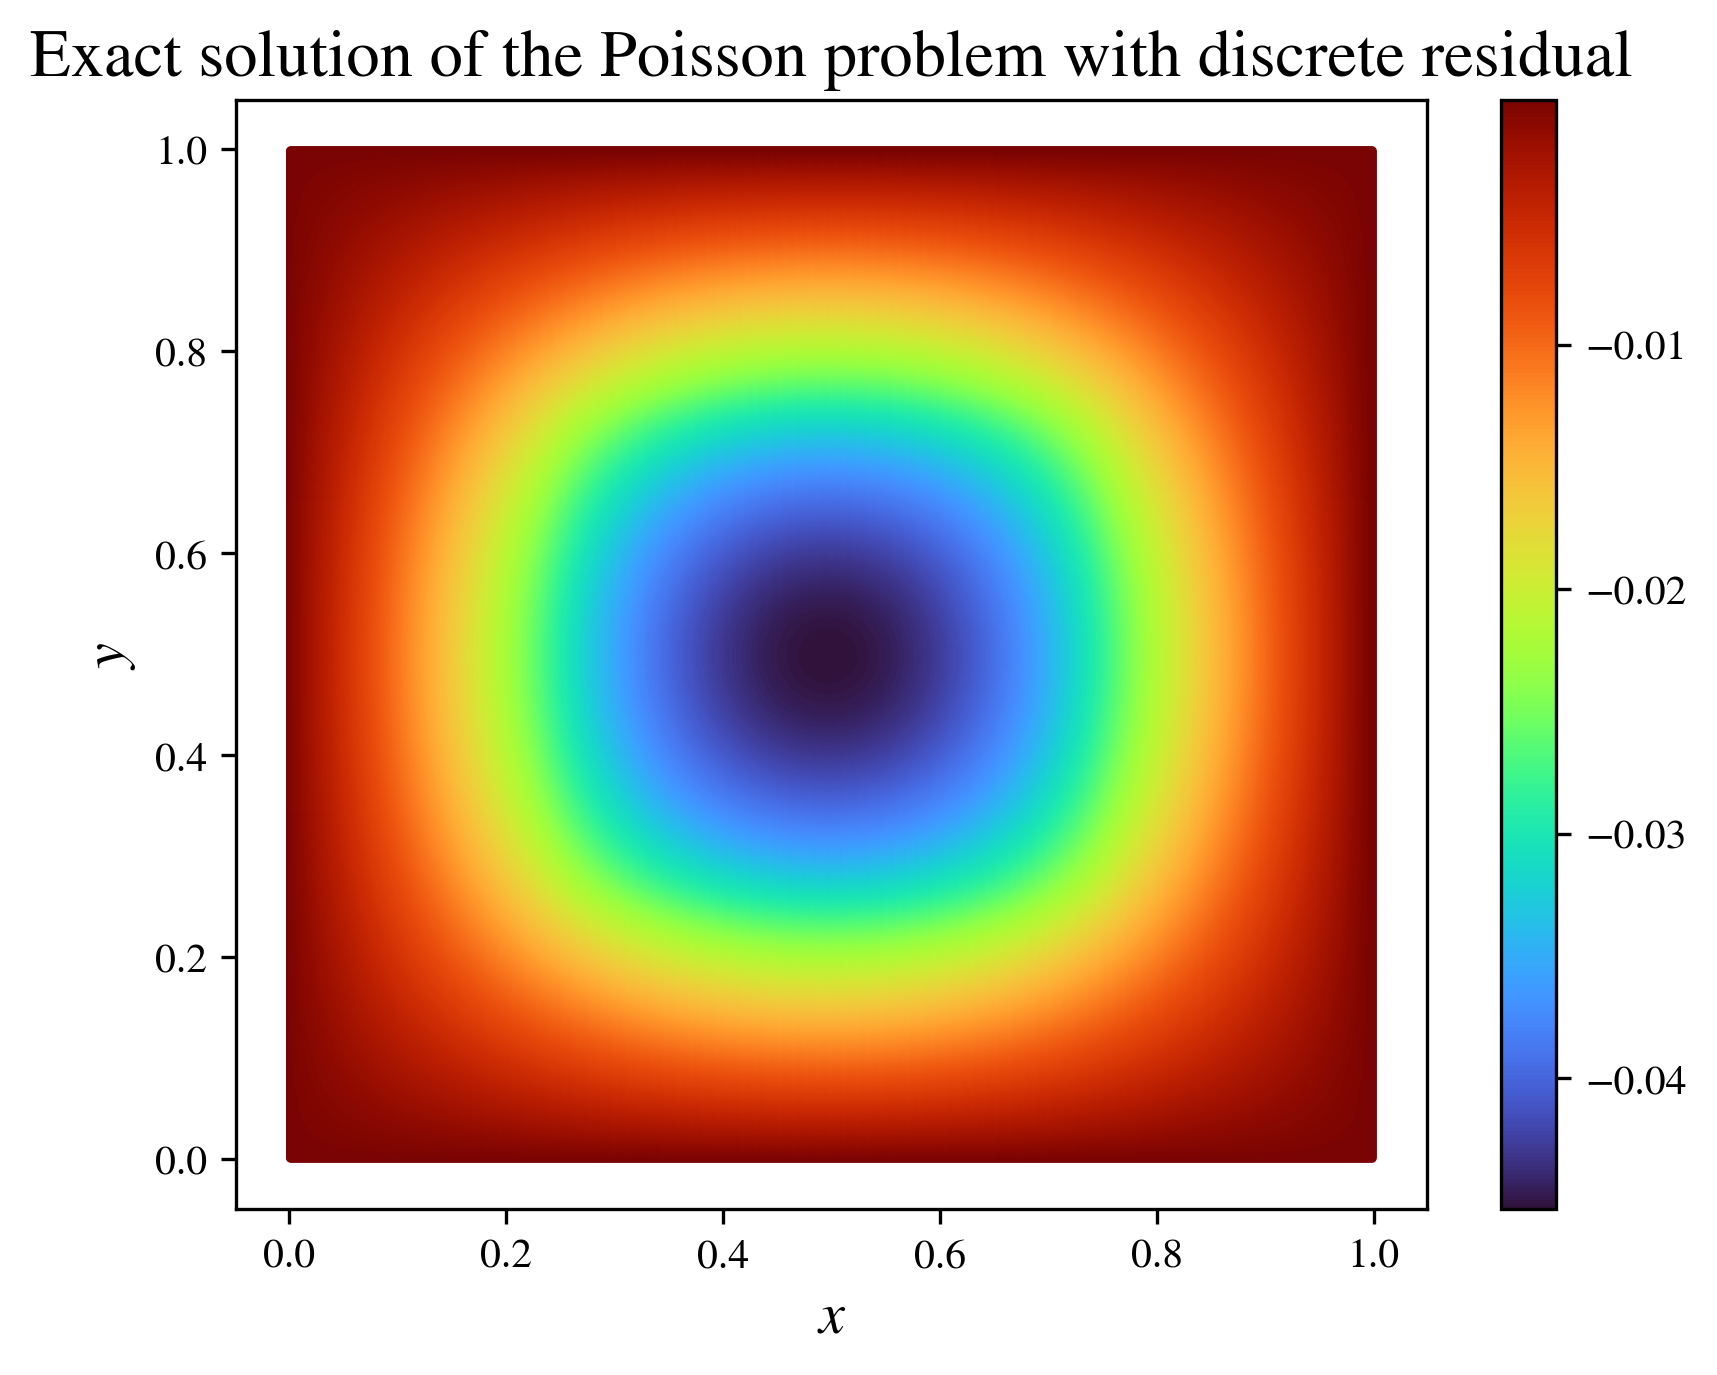

In [9]:
file = f"../true_solution.npz"
with onp.load(file) as true_file:
    true_sol = true_file["arr_0"]

plot_poisson(
    total_points,
    true_sol,
    title="Exact solution of the Poisson problem with discrete residual",
    savepath=save_path,
    save_name="discrete_Poisson_solution",
)

# plt.scatter(sorted_points[:, 0], sorted_points[:, 1], c=true_sol, cmap="turbo")
# plt.title("Exact Solution of the Poisson Problem with Discrete Residual")
# plt.xlabel("x")
# plt.ylabel("y")
# plt.colorbar()

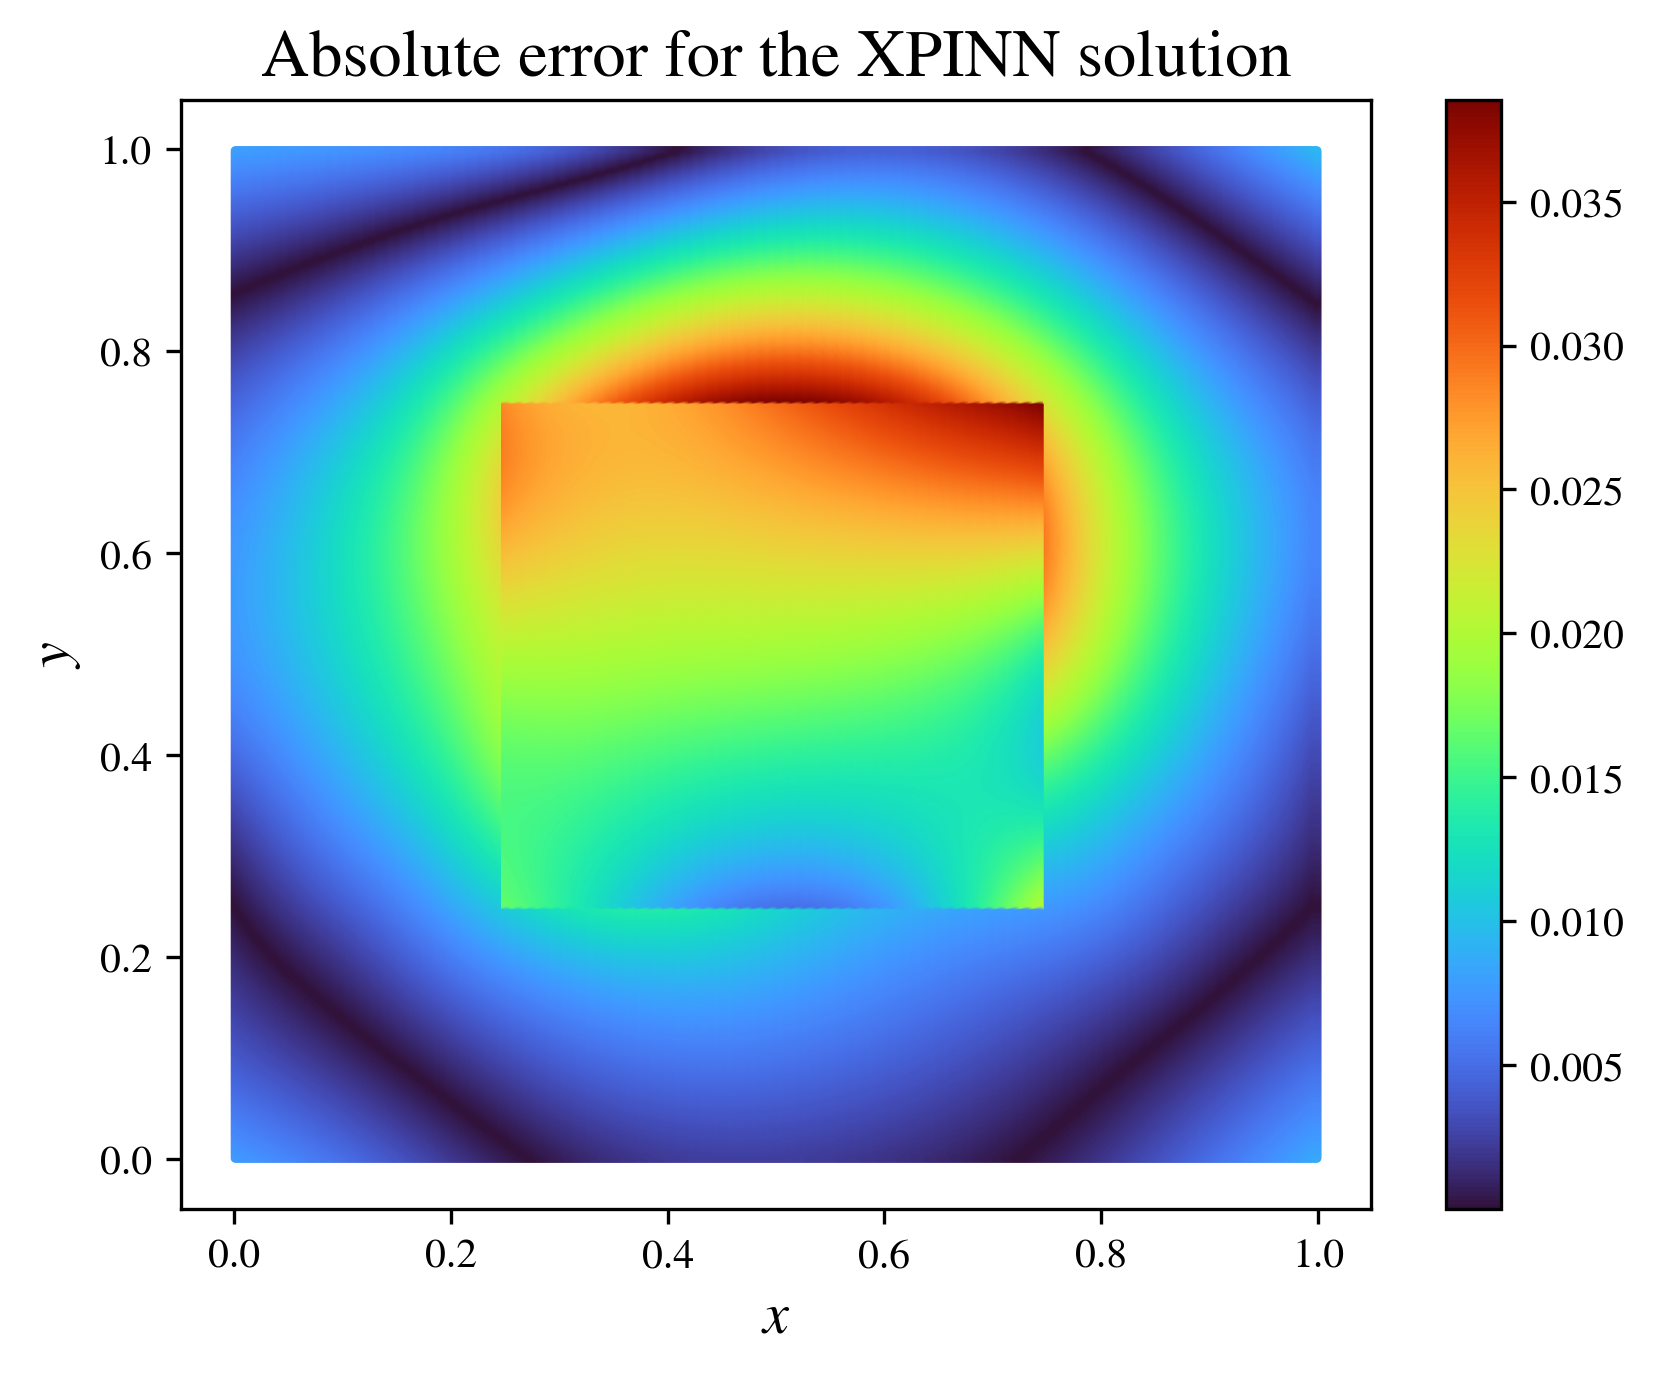

In [10]:
error = np.abs(true_sol - total_pred)

plot_poisson(
    total_points,
    error,
    title="Absolute error for the XPINN solution",
    savepath=save_path,
    save_name="discrete_xpinn_Poisson_error",
)

# plt.scatter(sorted_points[:, 0], sorted_points[:, 1], c=true_sol-sorted_pred, cmap="turbo")
# plt.title("Exact Solution of the Poisson Problem with Discrete Residual")
# plt.xlabel("x")
# plt.ylabel("y")
# plt.title("Absolute Error for the XPINN Solution")
# plt.colorbar()

In [11]:
sorted_indices = np.lexsort((total_points[:, 1], total_points[:, 0]))
sorted_pred = total_pred[sorted_indices]

# Getting true value
file = f"../true_solution.npz"
with onp.load(file) as true_file:
    true_sol = true_file["arr_0"]

true_integral = np.sqrt(np.sum(true_sol**2))
# Setting the L2 relative errors
l2_error = crude_rel_L2(sorted_pred, true_sol, true_integral)
print(l2_error)

0.6871539
